In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import winsound

In [2]:
df = pd.read_csv('final_data.csv', encoding='utf-8')
df = df.drop(['Unnamed: 0'], axis=1)
df

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
3662777,2023-10-31,8호선,2828,남위례,-535.0
3662778,2023-10-31,8호선,2828,남위례,-160.0
3662779,2023-10-31,8호선,2828,남위례,-133.0
3662780,2023-10-31,8호선,2828,남위례,-159.0


In [3]:
data1 = df[df['역명']=='서울역']
data1

,날짜,호선,역번호,역명,인원
0,2020-01-01,1호선,150,서울역,121.0
1,2020-01-01,1호선,150,서울역,-672.0
2,2020-01-01,1호선,150,서울역,-515.0
3,2020-01-01,1호선,150,서울역,-269.0
4,2020-01-01,1호선,150,서울역,-771.0
...,...,...,...,...,...
2872073,2022-12-30,1호선,150,서울역,434.0
2872074,2022-12-30,1호선,150,서울역,1126.0
2872075,2022-12-30,1호선,150,서울역,1037.0
2872076,2022-12-30,1호선,150,서울역,884.0


In [4]:
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 7

In [5]:
data = data1['인원']
data = data.values.astype('float32')
data = data.reshape(len(data), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

train_size = int(len(data) * 0.80)
test_size = len(data) - train_size

train = data[0:train_size]
test = data[train_size:len(data)]
x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(LSTM(128, input_shape=(None, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(None, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))
name = "lb7+lstm128+lstm64.jpg"
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()
hist = model.fit(x_train, y_train, epochs=10, batch_size=16)
p = model.predict(x_test)

plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
plt.savefig(name)
plt.clf()
print(mean_squared_error(y_test, p))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 128)         66560     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116033 (453.25 KB)
Trainable params: 116033 (453.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
1031/

<Figure size 640x480 with 0 Axes>

129/129 [==============================] - 1s 5ms/step


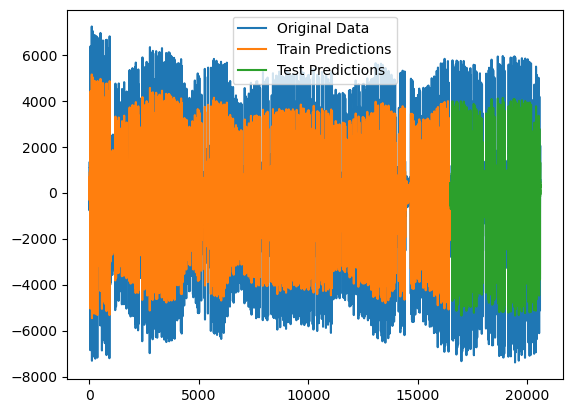

In [6]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(data)+2, :] = testPredict

plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')

plt.legend()
plt.show()

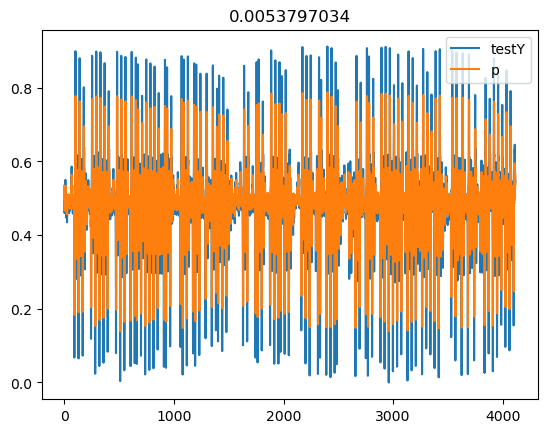

0.0053797034


In [7]:
plt.plot(y_test)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.title(mean_squared_error(y_test, p))
plt.show()
print(mean_squared_error(y_test, p))